**Introduction:**

Using simple random search. In our case, the cost function is just the reach error -- calculated by the reach error between the previous lamdba values and the current one. 

Error is defined as reach error: $ error = ||t-y||^2 $ and the perturbation term $ p_{2k+1} $ can be thought of a normal distribution.

$$ FR+ = FR - \frac{\nu}{N\delta} \sum_{n = 1}^N ( error(FR + \delta p) - error(FR) ) \cdot  p, p \sim \mathcal{N}(0,\sigma^2) $$

Note: p is a perturbation taken from a distribution with mean = 0

References:

[1] G. Cauwenberghs, “A Fast Stochastic Error-Descent Algorithm for Supervised Learning and Optimization,” in Advances in Neural Information Processing Systems 5, S. J. Hanson, J. D. Cowan, and C. L. Giles, Eds. Morgan-Kaufmann, 1993, pp. 244–251.

[2] R. Héliot, K. Ganguly, J. Jimenez, and J. M. Carmena, “Learning in Closed-Loop Brain–Machine Interfaces: Modeling and Experimental Validation,” IEEE Transactions on Systems, Man, and Cybernetics, Part B (Cybernetics), vol. 40, no. 5, pp. 1387–1397, Oct. 2010, doi: 10.1109/TSMCB.2009.2036931.


In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import seaborn

seaborn.set()


### Brain Modeling

In [2]:
# Brain Model 
###################
# Function that calculates firing rate from b, W, t
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (2.a, 2.b) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# targ_vect = 2 x 1
## OUTPUT
# newFR = N x 1
def brainFiringRate(lambda_vect, targ_vect):
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1)
    newFR = np.zeros( (np.size(lambda_vect, 0), 1) )
    newFR[:, 0] = np.matmul(lambda_vect, targ_vect_mult)
    return newFR

###################
# Function that alters the lambda paramters (b, W) for the brain
# B(t) = b + [Wx Wy][tx ty]' = firing rate
# This is Equation (6) in Heliot et al, 2010

## INPUT
# N = number of neurons
# lambda_vect = [b, W_x, W_y] for each neuron; N x 3
# delta_perturb = N x 1
# targ_vect = 2 x 1
## MIDDLE
# targ_vect_mult = 3 x 1 [1 t_x t_y]'
# targ_matx = N x 3
# delta_matx = N x 3
# next_term = delta_matx*delta_matx (element-wise mult) = N x 3
## OUTPUT
# lambda_vect_new = N x 3

def calcNextLambda(lambda_vect, gamma, delta_perturb, targ_vect):
    # This is the vector to multiply the lambda update term with = [1 t_x t_y]'
    num_neurons = np.size(lambda_vect.copy(), 0)
    targ_vect_mult = np.insert(targ_vect.copy(), 0, 1) # 3 x 1  
    targ_matx = (np.matlib.repmat(targ_vect_mult, num_neurons, 1)) # N x 3

    # next gradient term: \gamma*delta_perturb
    delta_matx = np.matlib.repmat(delta_perturb, 1, 3) # N x 3
    next_term = (delta_matx*targ_matx) # 3 x N

    lambda_vect_new = lambda_vect.copy() - (gamma*next_term)
    return lambda_vect_new


### Decoder Model

In [17]:
####################
# Decoder Model 
# Affine Function that calculates target postion from firing rate
# Y = D(f) = a + Kf --> Weiner Filter
# This is Equation (1) in Heliot et al, 2010

## INPUT
# N = number of neurons, d = dimension of target
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
# targ_vect = target position (T_x, Y_y)
## OUTPUT
# Cursor position = Y_x, Y_y
def decoder_findY(decoder_params, fr_curr, targ_vect):
    # check firing rate 
    # Start with affine decoder
    (a_vect_in, k_matx_in) = decoder_params
    a_vect = a_vect_in.copy()
    k_matx = k_matx_in.copy()
    cursor_pos = a_vect + np.dot(k_matx, np.squeeze(np.asarray(fr_curr)))
    return (cursor_pos)

# Function uses stochastic gradient descent to adjust decoder parameters
## INPUT
# decoder params = current a vector and K matrix (a = d x 1, K = d x N)
# fr_curr = current firing rate as a vector
## OUTPUT
# next decoder parameters = a_next, k_next
def calcNextDecoder(decoder_params, fr_curr):
    (a_vect, a_rate, a_dist, k_matx, k_rate, k_dist) = decoder_params
    cost_func_args = ( (a_vect, k_matx), fr_curr )
    # a vector
    a_grad = findErrorGrad(a_vect.copy(), A_VAR, a_dist,error_costFunc, cost_func_args)
    k_grad = findErrorGrad(k_matx.copy(), K_VAR, k_dist, error_costFunc, cost_func_args)
    print("adapt decoder = " + str(ADAPT_DEC))

    if (ADAPT_DEC == True):
        a_next = a_vect.copy().reshape(np.shape(a_grad)) - a_rate*a_grad
        k_next = k_matx.copy() - k_rate*k_grad
    else:
        a_next = a_vect
        k_next = k_matx

    return (a_next, k_next)

    
    

### Reach Error

In [4]:
####################
# Reach error
# This is Equation (3) in Heliot et al, 2010

## INPUT
# y_x, y_y = predicted cursor position
# t_x, t_y = target position
## OUTPUT
# norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def calcReachError(y_vect, t_vect):
    norm_vect = np.array(y_vect) - np.array(t_vect)
    return (np.linalg.norm(norm_vect, 2)**2)

## INPUT
# cost_func_params = decoder params (a vect, k matx) and current firing rate
## OUTPUT
# reach error = scalar; norm squared of (target position - cursor position)
# where reach error is the target position - cursor position
def error_costFunc(cost_func_params):
    decoder_params, firing_rate = cost_func_params
    y_vect = decoder_findY(decoder_params, firing_rate, TARGET_VECTOR_ERR)
    t_vect = TARGET_VECTOR_ERR
    return calcReachError(y_vect, t_vect)  


### Stochastic Error Descent: Update Calculation

In [5]:
## Stochastic Error Descent
# This is Equation (4) and Equation (5) in Heliot, 2010
# Derivation is found in Cauwenberghs, 1993 

# This function is one iteration of the error descent calcuation
## INPUT
# input_vect = vector to stochastically perturb
# input_var = FR_VAR, A_VAR OR K_VAR 
# param_dist = distribution from which perturbations to the input are selected
# cost_func = cost function (always reach error)
# cost_func_args = arguments to the cost function (depends on error cost function)
## OUTPUT
# errorGrad = gradient for updating parameter (input vect)
def findErrorGrad(input_vect, input_var, param_dist, cost_func, cost_func_args):
    # Un-nest everything
    (sigma, delta, num_dist) = param_dist
    (decoder_params, curr_fr) = cost_func_args
    (a_vect, k_matx) = decoder_params
    
    # Get size of input vector
    num_neurons = np.size(k_matx, 1)
    num_input_row = np.size(input_vect, 0) 
    num_input_column = 1
    if (input_vect.ndim > 1): 
        num_input_column = np.size(input_vect, 1)
    
    # What to perturb and input firing rate for error cost function
    input_vect = input_vect.copy().reshape(num_input_row, num_input_column)
    input_fr = curr_fr.copy().reshape(num_neurons, 1)
       
    error_sum = np.zeros((num_input_row, 1)) 
    error_grad = np.zeros((num_input_row, 1))
    perturb_rand = np.zeros((num_input_row, num_input_column, num_dist))
    
    
    for iC in range(num_input_column):
        for iN in range(num_input_row):
            perturb_rand[iN, iC, :] = np.random.uniform(0, sigma, num_dist) 
            # perturb_rand = N_input x N_dist
            # for each iteration, np.random.normal returns a N_dist x 1 array
    
    for iD in range(num_dist):
        # perturb_vect = stochastic pertrbation (amount of stochastic descent perturbation)
        perturb_vect = np.squeeze(perturb_rand[:, :, [iD]])
        perturb_vect = perturb_vect.copy().reshape(num_input_row, num_input_column)
        
        # find the delta error caused by the perturbation (direction to descend gradient in) 
        input_perturb = np.add(input_vect, delta*perturb_vect) 
        
        # Case 1: firing rate
        # error = reachError(a + K*fr')
        if (input_var == FR_VAR):        
            # Calculate error 
            perturb_cost_args = (decoder_params, input_perturb)   
            
        # case 2: a
        # error = reachError(a' + K*fr)
        elif (input_var == A_VAR):
            decoder_params_perturb = (input_perturb, k_matx)
            perturb_cost_args = (decoder_params_perturb, input_fr)

        # case 3: k
        # error = reachError(a + K'*fr)
        elif (input_var == K_VAR):
            decoder_params_perturb = (a_vect, input_perturb)
            perturb_cost_args = (decoder_params_perturb, input_fr)   
        
        # default: do nothing
        else:
            perturb_cost_args = cost_func_args
        
        error_perturb = cost_func(perturb_cost_args)   
        error_input = cost_func(cost_func_args)
        error_sum = np.add(error_sum, (error_perturb - error_input)*perturb_vect)

    error_grad = np.array(error_sum/(num_dist*delta))
    return error_grad



### Stochastic Gradient Descent: Update Step and Recalculate Error

In [6]:
# This function goes through and updates brain paramters over the num_iter times
def brain_adapt_sgd(brain_params, decoder_params, targ_vect, num_iter):
    (fr_init, fr_dist, lambda_init, lambda_rate) = brain_params
    (fr_sigma, fr_delta, fr_dist_size) = fr_dist
    (a_init, a_rate, a_dist, k_init, k_rate, k_dist) = decoder_params
    decoder_init = (a_init, k_init)
    grad_args_init = (decoder_init, fr_init)
    

    num_neurons = np.size(fr_init, 0)

    # Load display stuff
#     figsize = (fig_x , fig_y)
#     plt.figure(figsize=figsize)
#     ax1 = plt.subplot(1,3,1); ax1.grid('on')
#     ax2 = plt.subplot(1,3,2); ax2.grid('on')
#     ax3 = plt.subplot(1,3,3); ax3.grid('on')
    runs_num = 1

    # for sigma in sigma_list:
    for iR in range(runs_num):
        # Set the u vectors
        fr_vect = np.zeros( (num_neurons, 1, num_iter) )
        fr_vect[:, :, 0] = fr_init #fr init = num_neurons x 1
#         fr_vect[:, 0] = fr_init
        fr_final = np.zeros((num_neurons, 1, runs_num))
        re_final = np.zeros(runs_num)
        lambda_final = np.zeros((num_neurons, np.size(lambda_init, 1), runs_num))

        print("starting fr vect = " + str( fr_vect[:, :, 0] ))
        # lambda init = N x 3
        # lambda_vect = N x 3 X ITER
        lambda_vect = np.zeros( (num_neurons, np.size(lambda_init, 1), num_iter))
        lambda_vect[:,:,0] = lambda_init 

        # set the cost vector
        err_vect = np.zeros(num_iter)
        err_vect[0] = error_costFunc(grad_args_init)
        print('initial error = ' + str(err_vect[0]))

        # calculate the initial delta e
        grad_new = np.zeros(num_iter)
        grad_new = findErrorGrad(fr_init, FR_VAR, fr_dist, error_costFunc, grad_args_init)

        for iT in range(num_iter-1):
            ## calculate the new u 
            # (1) lambda+ = lambda - learn_rate*grad_error; B(lambda) = f
            lambda_next = calcNextLambda(lambda_vect[:, :, iT], lambda_rate, grad_new, targ_vect)
            lambda_vect[:,:, iT + 1] = lambda_next
            
            # (2) fr+ = B(lambda+)
            fr_next = brainFiringRate(lambda_next, targ_vect)
            fr_vect[:, :, iT+1] = fr_next
            

            # Update parameters for calculating error and calculate the new cost
            # (3) Calculate the new reach error 
            grad_args_next = (decoder_init, fr_next)
            err_next = np.array(error_costFunc(grad_args_next))
            err_vect[iT+1] = err_next


            # calculate the next error descent term to update FR again
            grad_new = findErrorGrad(fr_next, FR_VAR, fr_dist, error_costFunc, grad_args_next)
        
        fr_final[:, :, iR] = fr_next
        re_final[iR] = err_next
        lambda_final[:, :, iR] = lambda_next
#         ax1.plot(range(num_iter), err_vect, label=fr_sigma)
        
        
#         for iN in range(num_neurons):
#             ax2.plot(range(num_iter), fr_vect[iN, :], label=fr_sigma)  
# #             ax3.plot(range(numIter), lambda_vect[iN, 0, :], label = 'b') 
#             ax3.plot(range(num_iter), lambda_vect[iN, 1, :], label = 'Wx, sigma =' + str(fr_sigma)) 
#             # ax3.plot(range(numIter), lambda_vect[iN, 2, :], label = 'Wy, sigma =' + str(fr_sigma))

#         # Draw results
#         ax1.set_ylabel('$RE$', color='white')
#         ax1.set_xlabel('iteration', color='white')
#         ax1.tick_params(axis='x', colors='white')
#         ax1.tick_params(axis='y', colors='white')
#         ax1.set_title('RE' + ' N = ' + str(fr_dist_size) + ' Rate = ' + str(lambda_rate), color='white')
#         ax1.legend()

#         # ax2.plot(range(it_num),u_new)
#         ax2.set_ylabel('$FR$', color='white')
#         ax2.set_xlabel('iteration', color='white')
#         ax2.tick_params(axis='x', colors='white')
#         ax2.tick_params(axis='y', colors='white')
#         ax2.set_title('FR', color='white')
#         ax2.legend()

#         ax3.set_ylabel('$lambda$', color='white')
#         ax3.set_xlabel('iteration', color='white')
#         ax3.tick_params(axis='x', colors='white')
#         ax3.tick_params(axis='y', colors='white')
#         ax3.set_title('Lambda', color='white')
#         ax3.legend()

    return (re_final, fr_final, lambda_final)

### Generate New Trial

In [ ]:
def 
target_trial[0, iT + 1] = int(np.random.random_sample()*10)
        target_trial[1, iT + 1] = int(np.random.random_sample()*10)


### Set initial conditions

In [7]:
########
## Set some initial conditions here

# Helper info:
# fr_init = N x 1
# lambda init = N x 3
# baseline = N x 1
# target_vector = 2 x 1
# K_matx = 2 x N
# A = 2 x 1

BASELINE = np.array([5, 10, 15, 20])
NUM_NEURONS = len(BASELINE)
NUM_ITER = 50
NUM_DIM = 2
NUM_LAMBDA = NUM_DIM + 1

# lambda
lambda_init = np.zeros((NUM_NEURONS, NUM_LAMBDA))
lambda_init[:, 0] = np.array([BASELINE])        # lambda[0] = baseline
lambda_init[:, 1] = np.random.random_sample(np.shape(lambda_init[:, 0]))    # lambda[2] = w_y
lambda_init[:, 2] = np.random.random_sample(np.shape(lambda_init[:, 0]))*10 
# lambda_init[:, 1] = np.array([0.4, 0.6, 1, 2])  # lambda[1] = w_x
# lambda_init[:, 2] = np.array([3, 5, 4, 2])      # lambda[2] = w_y

# target position
TARGET_VECTOR = np.array( [2 ,3])
TARGET_ERROR = np.array([0, 2])
TARGET_VECTOR_ERR = TARGET_VECTOR + TARGET_ERROR

# firing rate 
fr_init = np.zeros( (NUM_NEURONS, 1) ) 
# fr_init[:, 0] = np.array(BASELINE)

# decoder initial paramters
K_MATX = np.random.random_sample( (2, NUM_NEURONS) ) # random float [0, 1)
A_VECT = (TARGET_VECTOR_ERR - np.matmul(K_MATX, BASELINE))

# SGD initial parameters
# IMPORTANT!
FR_VAR = 1
A_VAR = 2
K_VAR = 3
# Brain
FR_SIGMA = 1
FR_DELTA = 1
FR_DIST_SIZE = 100

# Decoder
# A_RATE = 1e-4
A_SIGMA = 1
A_DELTA = 1
A_DIST_SIZE = 100
# --
# K_RATE = 5e-4
K_SIGMA = 1
K_DELTA = 1
K_DIST_SIZE = 100

# display parameters
fig_x = 16
fig_y = 4

### Next Target

In [ ]:
def findNextTarget():
    

### Trial-to-trial adaptation

In [9]:
# NUM_TRIALS = 5
# NUM_RUNS = 2 # Has to be >1

# rate_list = [5e-3, 1e-3, 1e-4]
# # rate_list = [1e-4]

# for lambda_rate in rate_list:
#     ## BRAIN SIDE
#     # (sigma, delta, num_dist) = param_dist
#     FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
# #     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))
    
#     ## DECODER SIDE
#     A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
#     K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)
    
#     # target position
#     target_trial = np.zeros( (NUM_DIM, NUM_TRIALS) )
#     target_trial[:, 0] = TARGET_VECTOR_ERR
#     print("init target = " + str(TARGET_VECTOR_ERR))
#     print("K MATX INIT= " + str(K_MATX))
#     print("A VECT INIT = " + str(A_VECT))
    
#     ## VECTORS FOR TRIALS    
#     lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS) )
#     lambda_trial[:, :, 0] = lambda_init
#     print("lambda")
#     print(lambda_trial[:, :, 0])
    
#     fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
    
#     a_trial = np.zeros( (NUM_DIM, NUM_TRIALS) )
#     a_trial[:, 0] = np.array(A_VECT)
#     print("a")
#     print(a_trial[:, 0])
    
#     k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS) )
#     k_trial[:,:,  0] = K_MATX
#     print("K")
#     print(k_trial[:,:,  0] )
#     decoder_params = (a_trial[:, 0], A_RATE, A_DIST, k_trial[:,:,  0], K_RATE, K_DIST)
#     decoder_vals = (A_VECT, K_MATX)
    
#     re_startT = np.zeros(NUM_TRIALS)
#     re_endT = np.zeros(NUM_TRIALS)
    
#     for iT in range(NUM_TRIALS-1):
#         print("")
#         print("=========================================")
#         print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
#         print("Target = " + str(target_trial[:, iT]))
            
#         # calculate firing rate given lambda and decoder parameters with current target position 
#         fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT], target_trial[:, iT]))
#         fr_trial[:, :, iT] = fr_start
# #         print("firing rate = " + str(fr_trial[:, :, iT]))
        
#         # calculate reach error of firing rate at the beginning of th trial
#         cost_func_params = (decoder_vals, fr_trial[:, :, iT]) 
#         re_startT[iT] = error_costFunc(cost_func_params)
#         print("re start = " + str(re_startT[iT]))
        
#         # Run through trial and see the reach at the end
#         brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT], lambda_rate)
#         re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, iT], NUM_RUNS)
        
#         re_endT[iT] = re_run
#         print("re end = " + str(re_endT[iT]))
#         print("re diff = " + str(re_endT[iT] - re_startT[iT]))
#         lambda_trial[:, :, iT + 1] = np.squeeze(lambda_run)
# #         print("lambda = " + str(lambda_run))
        
#         # change to new target
#         target_trial[0, iT + 1] = int(np.random.random_sample()*10)
#         target_trial[1, iT + 1] = int(np.random.random_sample()*10)

#     plt.plot(np.arange(0, NUM_TRIALS, 1), re_endT[:] - re_startT[:])
#     plt.xlabel('Trials', color='white')
#     plt.ylabel('Difference in RE', color='white')
#     plt.xticks(color='white')
#     plt.yticks(color='white')
#     plt.title('Difference between End RE and Initial RE across trials, learn rate = ' + str(lambda_rate), color = 'white')
#     plt.show()
#     plt.plot(np.arange(0, NUM_TRIALS, 1), re_startT[:])
#     plt.xlabel('Trials' )#, color='white')
#     plt.ylabel('Starting RE')#, color='white')
# #     plt.xticks(color='white')
# #     plt.yticks(color='white')
#     plt.title('Initial RE across trials, learn rate = ' + str(lambda_rate)) #, color = 'white')
#     plt.show()
    
#     plt.plot(np.arange(50, NUM_TRIALS, 1), re_startT[50: len(re_startT)])
#     plt.xlabel('Trials')#, color='white')
#     plt.ylabel('Starting RE')#, color='white')
# #     plt.xticks(color='white')
# #     plt.yticks(color='white')
#     plt.title('Initial RE across last 50 trials, learn rate = ' + str(lambda_rate)) #, color = 'white')
#     plt.show()
    

init target = [2 5]
K MATX INIT= [[0.75821865 0.90297747 0.06370385 0.39684962]
 [0.86032187 0.25595124 0.8417775  0.73175996]]
A VECT INIT = [-19.71341825 -29.12298351]
lambda
[[ 5.          0.09221791  8.32465611]
 [10.          0.85234069  8.75299292]
 [15.          0.35742063  9.62091003]
 [20.          0.16218141  5.75069957]]
a
[-19.71341825 -29.12298351]
K
[[0.75821865 0.90297747 0.06370385 0.39684962]
 [0.86032187 0.25595124 0.8417775  0.73175996]]


NameError: name 'A_RATE' is not defined

### Adaptive Decoder

init target = [2 5]
K MATX INIT= [[0.75821865 0.90297747 0.06370385 0.39684962]
 [0.86032187 0.25595124 0.8417775  0.73175996]]
A VECT INIT = [-19.71341825 -29.12298351]
lambda
[[ 5.          0.09221791  8.32465611]
 [10.          0.85234069  8.75299292]
 [15.          0.35742063  9.62091003]
 [20.          0.16218141  5.75069957]]
a
[-19.71341825 -29.12298351]
K
[[0.75821865 0.90297747 0.06370385 0.39684962]
 [0.86032187 0.25595124 0.8417775  0.73175996]]

Trial #0 | lambda learn rate = 0.0001
Target = [2. 5.]
re start = 19735.400786836526
starting fr vect = [[46.80771638]
 [55.46964596]
 [63.81939139]
 [49.07786066]]
initial error = 19735.400786836526
adapt decoder = True
re end = 19000.000838144722
re diff = -735.3999486918037
a = [-20.75033292 -30.07817376]
k = [[0.73953651 0.88417736 0.04240835 0.37858938]
 [0.84045644 0.23769877 0.82416631 0.71310315]]

Trial #1 | lambda learn rate = 0.0001
Target = [8. 0.]
re start = 62.95162743849249
starting fr vect = [[ 5.31164778]
 [16.39867

adapt decoder = True
re end = 2987.4121488149017
re diff = -12329.709488252876
a = [-28.18875731 -37.12113516]
k = [[ 0.54911881  0.69677066 -0.15017204  0.18380078]
 [ 0.6431397   0.03888735  0.6243084   0.52100387]]

Trial #20 | lambda learn rate = 0.0001
Target = [5. 8.]
re start = 30452.15805059136
starting fr vect = [[56.26123182]
 [69.35169529]
 [78.88211604]
 [51.62783568]]
initial error = 7493.26547780831
adapt decoder = True
re end = 7138.133832064783
re diff = -23314.024218526574
a = [-28.59297716 -37.54663006]
k = [[ 0.5331311   0.68094677 -0.16500079  0.16687266]
 [ 0.62653931  0.02034308  0.60547638  0.50277259]]

Trial #21 | lambda learn rate = 0.0001
Target = [2. 0.]
re start = 31.20795231701388
starting fr vect = [[ 2.81238227]
 [ 9.47902496]
 [13.47729357]
 [18.06175428]]
initial error = 1022.6135572817602
adapt decoder = True
re end = 1020.1866281293213
re diff = 988.9786758123074
a = [-28.64344928 -37.60518105]
k = [[ 0.53336475  0.6812     -0.16477586  0.16710575]
 

adapt decoder = True
re end = 803.8077686189515
re diff = 309.8852646557062
a = [-30.35809051 -39.24800523]
k = [[ 0.43752114  0.58084891 -0.26441188  0.06578366]
 [ 0.52563648 -0.08215354  0.50176911  0.40641754]]

Trial #38 | lambda learn rate = 0.0001
Target = [6. 1.]
re start = 36.54187915486539
starting fr vect = [[ 5.2238853 ]
 [15.76768995]
 [18.51833107]
 [18.3890076 ]]
initial error = 1282.8557215416033
adapt decoder = True
re end = 1270.6755248296618
re diff = 1234.1336456747963
a = [-30.42282821 -39.31508616]
k = [[ 0.43780176  0.58110423 -0.26414411  0.06605937]
 [ 0.52589148 -0.08189583  0.50202724  0.40670085]]

Trial #39 | lambda learn rate = 0.0001
Target = [0. 4.]
re start = 7616.958228275509
starting fr vect = [[31.32666384]
 [38.40987   ]
 [46.75706918]
 [36.20285731]]
initial error = 92.27843475002983
adapt decoder = True
re end = 92.2075804259921
re diff = -7524.750647849517
a = [-30.44424791 -39.33728042]
k = [[ 0.43382297  0.57722304 -0.26786799  0.06230391]
 [ 0

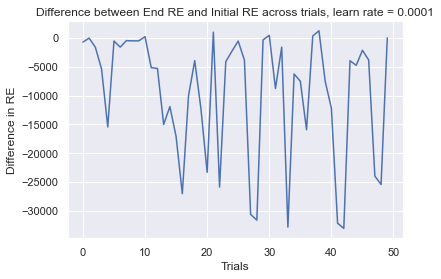

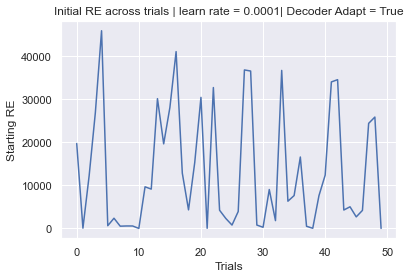

In [51]:
NUM_TRIALS = 50
NUM_RUNS = 2 # Has to be >1

# rate_list = [5e-3, 1e-3, 1e-4]
rate_list = [1e-4]
A_RATE = 1e-4
K_RATE = 5e-7
ADAPT_TRIALS = 1

ADAPT_DEC = True
for lambda_rate in rate_list:
    ## BRAIN SIDE
    FR_DIST = (FR_SIGMA, FR_DELTA, FR_DIST_SIZE)
#     fr_init[:, 0] = np.array(brainFiringRate(lambda_init, TARGET_VECTOR_ERR))
    
    ## DECODER SIDE
    A_DIST = (A_SIGMA, A_DELTA, A_DIST_SIZE)
    K_DIST = (K_SIGMA, K_DELTA, K_DIST_SIZE)
    
    # target position -- new target represents a new trial
    target_trial = np.zeros( (NUM_DIM, NUM_TRIALS) )
    target_trial[:, 0] = TARGET_VECTOR_ERR
    print("init target = " + str(TARGET_VECTOR_ERR))
    print("K MATX INIT= " + str(K_MATX))
    print("A VECT INIT = " + str(A_VECT))
    
    ## VECTORS FOR TRIALS    
    lambda_trial = np.zeros( (NUM_NEURONS, NUM_LAMBDA, NUM_TRIALS) )
    lambda_trial[:, :, 0] = lambda_init
    print("lambda")
    print(lambda_trial[:, :, 0])
    
    fr_trial = np.zeros( (NUM_NEURONS, 1, NUM_TRIALS) )
    
    a_trial = np.zeros( (NUM_DIM, NUM_TRIALS) )
    a_trial[:, 0] = np.array(A_VECT)
    print("a")
    print(a_trial[:, 0])
    
    k_trial = np.zeros( (NUM_DIM, NUM_NEURONS, NUM_TRIALS) )
    k_trial[:,:,  0] = K_MATX
    print("K")
    print(k_trial[:,:, 0] )
    decoder_params = (a_trial[:, 0], A_RATE, A_DIST, k_trial[:,:,  0], K_RATE, K_DIST)
    decoder_vals = (A_VECT, K_MATX)
    
    re_startT = np.zeros(NUM_TRIALS)
    re_endT = np.zeros(NUM_TRIALS)
    
    for iT in range(NUM_TRIALS-1):
        print("")
        print("=========================================")
        print("Trial #" + str(iT) + " | lambda learn rate = " + str(lambda_rate))
        print("Target = " + str(target_trial[:, iT]))
            
        # calculate firing rate given lambda and decoder parameters with current target position 
        fr_start = np.array(brainFiringRate(lambda_trial[:, :, iT], target_trial[:, iT]))
        fr_trial[:, :, iT] = fr_start
        
        # calculate reach error of firing rate at the beginning of th trial
        cost_func_params = (decoder_vals, fr_trial[:, :, iT]) 
        re_startT[iT] = error_costFunc(cost_func_params)
        print("re start = " + str(re_startT[iT]))
        
        # Run through trial and see the reach at the end        
        # current brain and decoder params
        brain_params = (fr_trial[:, :, iT], FR_DIST, lambda_trial[:, :, iT], lambda_rate)
        decoder_params = (a_trial[:, iT], A_RATE, A_DIST, k_trial[:, :,  iT], K_RATE, K_DIST)
        
        # adapt brain and decoder (together here)
        re_run, fr_run, lambda_run = brain_adapt_sgd(brain_params, decoder_params, target_trial[:, iT], NUM_RUNS)
        
        if (iT%ADAPT_TRIALS == 0):
            ADAPT_DEC = True
        else:
            ADAPT_DEC = False
        
        a_run, k_run = calcNextDecoder(decoder_params, fr_trial[:, :, iT])
        
        
        re_endT[iT] = re_run
        print("re end = " + str(re_endT[iT]))
        print("re diff = " + str(re_endT[iT] - re_startT[iT]))
        
        # update the parameters
        lambda_trial[:, :, iT + 1] = np.squeeze(lambda_run)
        a_trial[:, iT + 1] = np.squeeze(a_run)
        k_trial[:, :, iT + 1] = np.squeeze(k_run)
        print("a = " + str(a_trial[:, iT + 1]))
        print("k = " + str(k_trial[:, :, iT + 1]))
        
        # change to new target
        target_trial[:, iT + 1] = findNextTarget()
    
    plt.plot(np.arange(0, NUM_TRIALS, 1), re_endT[:] - re_startT[:])
    plt.xlabel('Trials')
    plt.ylabel('Difference in RE')
    plt.title('Difference between End RE and Initial RE across trials, learn rate = ' + str(lambda_rate))
    plt.show()
    plt.plot(np.arange(0, NUM_TRIALS, 1), re_startT[:])
    plt.xlabel('Trials' )#, color='white')
    plt.ylabel('Starting RE')#, color='white')
    plt.title('Initial RE across trials | learn rate = ' + str(lambda_rate) + '| Decoder Adapt = ' + str(ADAPT_DEC)) #, color = 'white')
    plt.show()
    
    